# https://github.com/BrandonReyes0609/VP-Lab2.git

Laboratorio 2 Visión por computadora

 - Nancy Mazariegos – 22513 
 - Brandon Reyes – 22992 
 - Santiago Pereira – 22318 

# Task 1

si se quiere hacer efecto rayado a fotografia

In [1]:
import cv2
import numpy as np
import math


ruta_foto = "imagenes\imagen1.jpg"

nuevo_ancho = 512
nuevo_alto = 512

amplitud_ruido = 35.0   
frecuencia_x = 0.03     
frecuencia_y = 0.017    


imagen_gris = cv2.imread(ruta_foto, cv2.IMREAD_GRAYSCALE)
if imagen_gris is None:
    raise FileNotFoundError("No se encontró el archivo 'mi_foto.jpg'")


imagen_redimensionada = cv2.resize(imagen_gris, (nuevo_ancho, nuevo_alto))


alto = imagen_redimensionada.shape[0]
ancho = imagen_redimensionada.shape[1]
imagen_float = imagen_redimensionada.astype(np.float32).copy()
ruido = np.zeros((alto, ancho), dtype=np.float32)


pi_por_dos = 2.0 * math.pi  

i = 0
while i < alto:
    j = 0
    while j < ancho:
        argumento = (frecuencia_x * float(j)) + (frecuencia_y * float(i))
        argumento = pi_por_dos * argumento
        valor_seno = math.sin(argumento)
        valor_ruido = amplitud_ruido * valor_seno
        ruido[i, j] = valor_ruido

        j = j + 1
    i = i + 1


imagen_con_ruido_float = np.zeros((alto, ancho), dtype=np.float32)

i = 0
while i < alto:
    j = 0
    while j < ancho:
        valor_imagen = imagen_float[i, j]
        valor_del_ruido = ruido[i, j]
        suma = valor_imagen + valor_del_ruido
        imagen_con_ruido_float[i, j] = suma

        j = j + 1
    i = i + 1


imagen_con_ruido_uint8 = np.zeros((alto, ancho), dtype=np.uint8)

i = 0
while i < alto:
    j = 0
    while j < ancho:
        valor = imagen_con_ruido_float[i, j]

        if valor < 0.0:
            valor = 0.0

        if valor > 255.0:
            valor = 255.0

        imagen_con_ruido_uint8[i, j] = int(valor)

        j = j + 1
    i = i + 1


nombre_salida = "periodic_noise.jpg"
guardado_ok = cv2.imwrite(nombre_salida, imagen_con_ruido_uint8)

if guardado_ok:
    print("Imagen generada y guardada como periodic_noise.jpg")
else:
    print("Ocurrió un problema al guardar la imagen de salida")


<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
C:\Users\brand\AppData\Local\Temp\ipykernel_24036\1492616495.py:6: SyntaxWarning: invalid escape sequence '\i'
  ruta_foto = "imagenes\imagen1.jpg"


Imagen generada y guardada como periodic_noise.jpg


### Codigo para la task 1

Tamaño de la imagen: 512x512
Media (sin DC): 8.25366199517557
Desviación (sin DC): 0.8993889896580939
Umbral para picos: 10.95182896414985
Candidatos encontrados: 2152
Picos seleccionados: 8


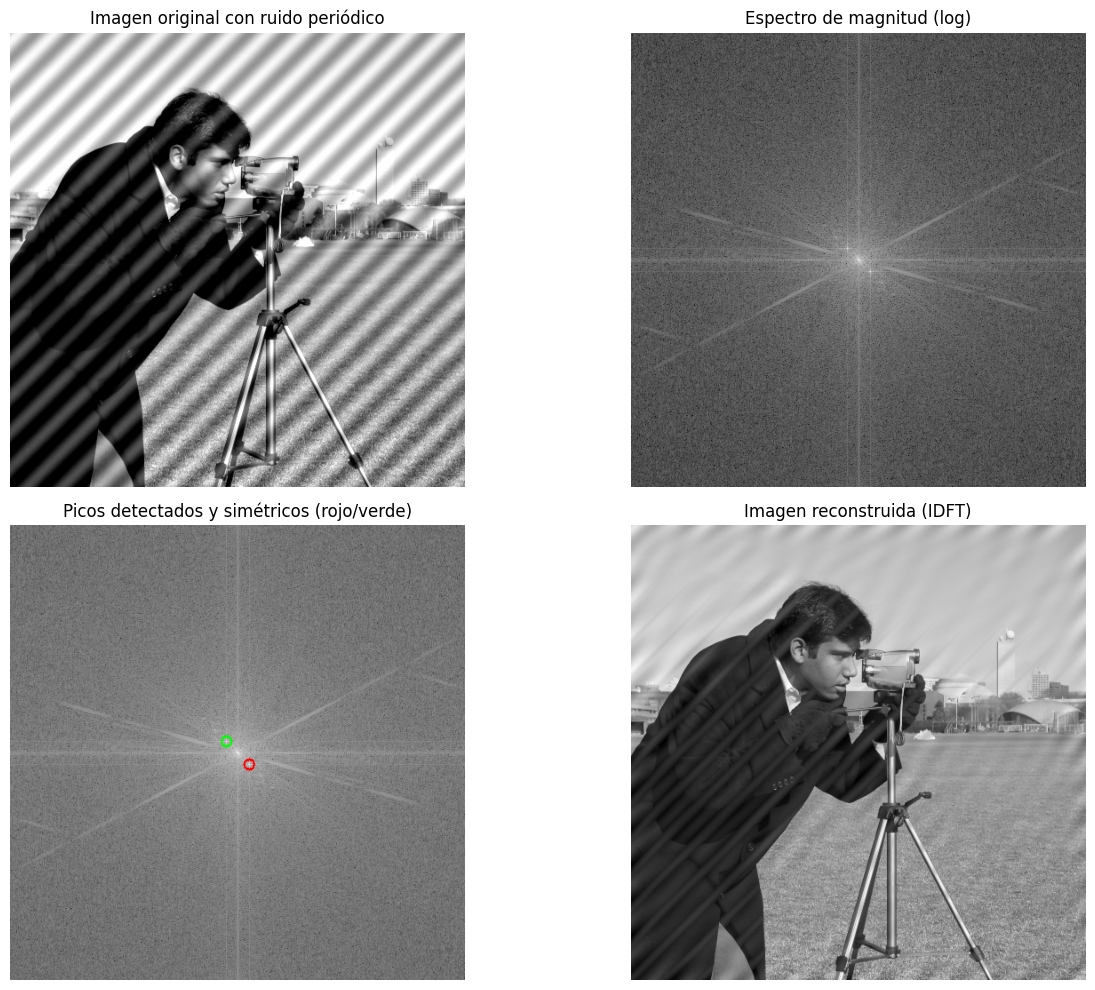

Archivos guardados:
 - resultado_task1_espectro_log.png
 - resultado_task1_picos_marcados.png
 - resultado_task1_reconstruida.png


In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


ruta_imagen = "imagenes/periodic_noise.jpg"  

radio_dc_exclusion = 15   
k_veces_desviacion = 3.0  
cantidad_picos = 8       
radio_notch = 6           


img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se encontró 'periodic_noise.jpg'")

img_float = img.astype(np.float32)

alto = img.shape[0]
ancho = img.shape[1]

print("Tamaño de la imagen: " + str(ancho) + "x" + str(alto))


fft2 = np.fft.fft2(img_float)      
fft2_shift = np.fft.fftshift(fft2) 
 

magnitud = np.abs(fft2_shift)
magnitud_log = np.log(1.0 + magnitud)  

cy = int(alto / 2)
cx = int(ancho / 2)

suma = 0.0
suma_cuadrados = 0.0
contador = 0

i = 0
while i < alto:
    j = 0
    while j < ancho:
        dy = i - cy
        dx = j - cx
        distancia2 = (dy * dy) + (dx * dx)

        if distancia2 > (radio_dc_exclusion * radio_dc_exclusion):
            valor = float(magnitud_log[i, j])
            suma = suma + valor
            suma_cuadrados = suma_cuadrados + (valor * valor)
            contador = contador + 1
        j = j + 1
    i = i + 1

if contador == 0:
    raise ValueError("No se pudo calcular media/std (contador=0)")

media = suma / float(contador)
varianza = (suma_cuadrados / float(contador)) - (media * media)
if varianza < 0.0:
    varianza = 0.0
desviacion = math.sqrt(varianza)

umbral = media + (k_veces_desviacion * desviacion)

print("Media (sin DC): " + str(media))
print("Desviación (sin DC): " + str(desviacion))
print("Umbral para picos: " + str(umbral))

candidatos = []  

i = 0
while i < alto:
    j = 0
    while j < ancho:
        dy = i - cy
        dx = j - cx
        distancia2 = (dy * dy) + (dx * dx)

        if distancia2 > (radio_dc_exclusion * radio_dc_exclusion):
            valor = float(magnitud_log[i, j])
            if valor > umbral:
                distancia = math.sqrt(float(distancia2))
                # Guardamos para luego ordenar/filtrar
                candidatos.append((valor, i, j, distancia))
        j = j + 1
    i = i + 1

print("Candidatos encontrados: " + str(len(candidatos)))

candidatos_ordenados = sorted(candidatos, key=lambda t: (t[0], t[3]), reverse=True)

picos_seleccionados = []
indice = 0
while indice < len(candidatos_ordenados) and indice < cantidad_picos:
    picos_seleccionados.append(candidatos_ordenados[indice])
    indice = indice + 1

print("Picos seleccionados: " + str(len(picos_seleccionados)))

mask = np.ones((alto, ancho), dtype=np.float32)

def anular_circulo_en_mascara(mascara, centro_x, centro_y, radio):
    i = 0
    while i < mascara.shape[0]:
        j = 0
        while j < mascara.shape[1]:
            dy = i - centro_y
            dx = j - centro_x
            dist2 = (dy * dy) + (dx * dx)
            if dist2 <= (radio * radio):
                mascara[i, j] = 0.0
            j = j + 1
        i = i + 1


magnitude_log_norm = magnitud_log / magnitud_log.max()
magnitude_log_uint8 = (magnitude_log_norm * 255.0).astype(np.uint8)
espectro_bgr = cv2.cvtColor(magnitude_log_uint8, cv2.COLOR_GRAY2BGR)

idx = 0
while idx < len(picos_seleccionados):
    valor_log, py, px, dist = picos_seleccionados[idx]

    dy = py - cy
    dx = px - cx
    if (dy * dy) + (dx * dx) <= (radio_dc_exclusion * radio_dc_exclusion):
        idx = idx + 1
        continue

    anular_circulo_en_mascara(mask, px, py, radio_notch)

    sx = (2 * cx) - px
    sy = (2 * cy) - py
    anular_circulo_en_mascara(mask, sx, sy, radio_notch)

    cv2.circle(espectro_bgr, (px, py), radio_notch, (0, 0, 255), 1)  # rojo
    cv2.circle(espectro_bgr, (sx, sy), radio_notch, (0, 255, 0), 1)  # verde

    idx = idx + 1

i = 0
while i < alto:
    j = 0
    while j < ancho:
        dy = i - cy
        dx = j - cx
        dist2 = (dy * dy) + (dx * dx)
        if dist2 <= (radio_dc_exclusion * radio_dc_exclusion):
            mask[i, j] = 1.0
        j = j + 1
    i = i + 1


fft2_filtrado = fft2_shift * mask
fft2_ishift = np.fft.ifftshift(fft2_filtrado)
img_rec_complex = np.fft.ifft2(fft2_ishift)
img_rec_real = np.real(img_rec_complex)

min_val = float(img_rec_real.min())
max_val = float(img_rec_real.max())
rango = max_val - min_val
if rango == 0.0:
    rango = 1.0

img_rec_norm = np.zeros((alto, ancho), dtype=np.float32)

i = 0
while i < alto:
    j = 0
    while j < ancho:
        valor = float(img_rec_real[i, j])
        valor = (valor - min_val) / rango
        if valor < 0.0:
            valor = 0.0
        if valor > 1.0:
            valor = 1.0
        img_rec_norm[i, j] = valor
        j = j + 1
    i = i + 1

img_rec_uint8 = (img_rec_norm * 255.0).astype(np.uint8)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Imagen original con ruido periódico")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(magnitud_log, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(espectro_bgr, cv2.COLOR_BGR2RGB))
plt.title("Picos detectados y simétricos (rojo/verde)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_rec_uint8, cmap="gray")
plt.title("Imagen reconstruida (IDFT)")
plt.axis("off")

plt.tight_layout()
plt.show()

cv2.imwrite("resultado_task1_espectro_log.png", (magnitud_log / magnitud_log.max() * 255.0).astype(np.uint8))
cv2.imwrite("resultado_task1_picos_marcados.png", espectro_bgr)
cv2.imwrite("resultado_task1_reconstruida.png", img_rec_uint8)

print("Archivos guardados:")
print(" - resultado_task1_espectro_log.png")
print(" - resultado_task1_picos_marcados.png")
print(" - resultado_task1_reconstruida.png")


Un filto promedio de 5x5 es atenuado de forma global todas las frecuacnias maximas y por eso se elimina dettalles sin eliminar de forma eficiente el ruido, que está centrado en frecuencias muy especificas y orientado. En cambio el filtro notch en el dominio de Fourrier suprime solo las frecuencia del ruido y preserva el resto de la información, asi mismo logra una restauración más limpia.